In [1]:
import pandas as pd
df = pd.read_csv("data/dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 6 columns):
uri             object
is_static       bool
http_version    object
has_referer     bool
method          object
label           int64
dtypes: bool(2), int64(1), object(3)
memory usage: 162.1+ MB


In [2]:
df['label'].value_counts()

0    4994891
1       5109
Name: label, dtype: int64

In [3]:
df.head()

,uri,is_static,http_version,has_referer,method,label
0,/login,False,v1.1,True,GET,0
1,/product/72470,False,v1.1,True,GET,0
2,/media/catalog/small_image/210x210/203561673.jpg,True,v1.1,True,GET,0
3,/blog/images/logo.png,True,v1.1,False,GET,0
4,/data/files/images/menu.jpg,True,v2.0,True,GET,0


In [4]:
pd.set_option('display.max_colwidth', 80)
df[df['label'] == 1].head()

,uri,is_static,http_version,has_referer,method,label
32,/.git/config,False,v1.1,False,GET,1
768,/?x=%3Cscript%3Ealert%281%29%3C%2Fscript%3E,False,v1.1,False,GET,1
1056,/?x=INSERT+INTO+users20VALUES%281%2C+%27ddd%27%29,False,v1.1,False,GET,1
2872,/?x=cmd.exe,True,v1.1,False,GET,1
3917,/?x=..%2F..%2F..%2F..%2Fetc%2Fpasswd,False,v1.1,False,GET,1


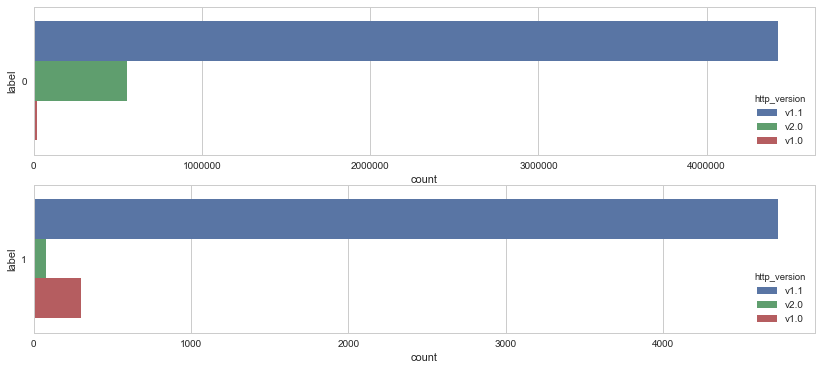

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

def plot_attribute_countplot_by_label(dataset, attribute_name, value_list=None):
    if value_list is None:
        value_list = dataset[attribute_name].unique()
    fig, (axis1, axis2) = plt.subplots(2, 1, figsize=(14, len(value_list) * 2))
    sns.countplot(y='label', hue=attribute_name, hue_order=value_list, 
                  data=dataset[dataset['label'] == 0], ax=axis1)
    sns.countplot(y='label', hue=attribute_name, hue_order=value_list, 
                  data=dataset[dataset['label'] == 1], ax=axis2)
    
plot_attribute_countplot_by_label(df, "http_version")

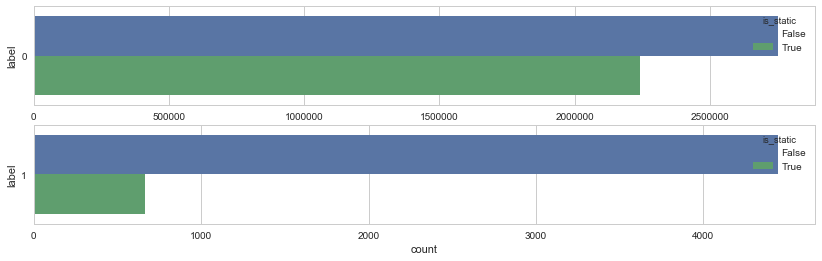

In [6]:
plot_attribute_countplot_by_label(df, "is_static")

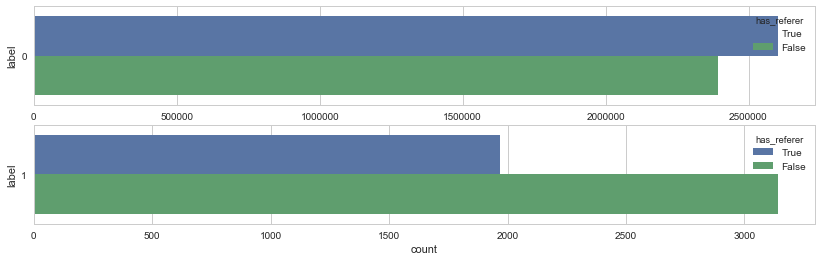

In [7]:
plot_attribute_countplot_by_label(df, "has_referer")

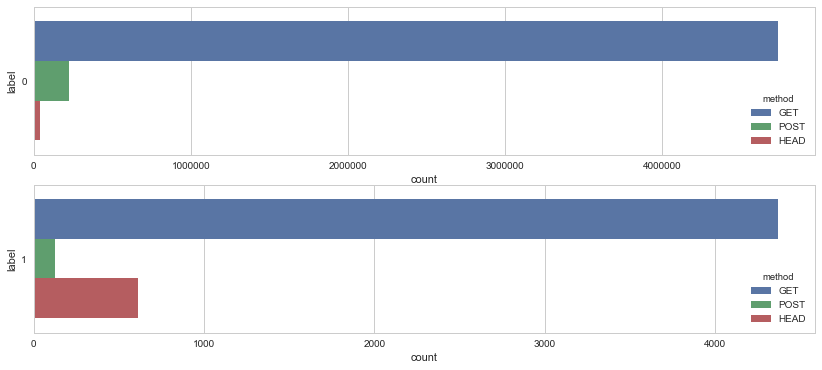

In [8]:
plot_attribute_countplot_by_label(df, "method", ["GET", "POST", "HEAD"])

In [9]:
from sklearn.model_selection import train_test_split
attributes = ['uri', 'is_static', 'http_version', 'has_referer', 'method']
x_train, x_test, y_train, y_test = train_test_split(df[attributes], df['label'], test_size=0.2, 
                                                    stratify=df['label'], random_state=0)

In [10]:
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.2, 
                                                  stratify=y_train, random_state=0)
print('Train:', len(y_train), 'Dev:', len(y_dev), 'Test:', len(y_test))

Train: 3200000 Dev: 800000 Test: 1000000


In [11]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(analyzer='char', min_df=10)
n_grams_train = count_vectorizer.fit_transform(x_train['uri'])
n_grams_dev = count_vectorizer.transform(x_dev['uri'])

print('Number of features:', len(count_vectorizer.vocabulary_))

Number of features: 74


In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

sgd = SGDClassifier(random_state=0)
sgd.fit(n_grams_train, y_train)
y_pred_sgd = sgd.predict(n_grams_dev)
print("SGDClassifier accuracy:", accuracy_score(y_dev, y_pred_sgd))

SGDClassifier accuracy: 0.99882


In [13]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(n_grams_train, y_train)
print("DummyClassifier accuracy:", dummy_clf.score(n_grams_dev, y_dev))

DummyClassifier accuracy: 0.99897875


In [14]:
from sklearn.metrics import precision_score, recall_score
print('Precision:', precision_score(y_dev, y_pred_sgd))
print('Recall:', recall_score(y_dev, y_pred_sgd))

Precision: 0.414535666218
Recall: 0.376988984088


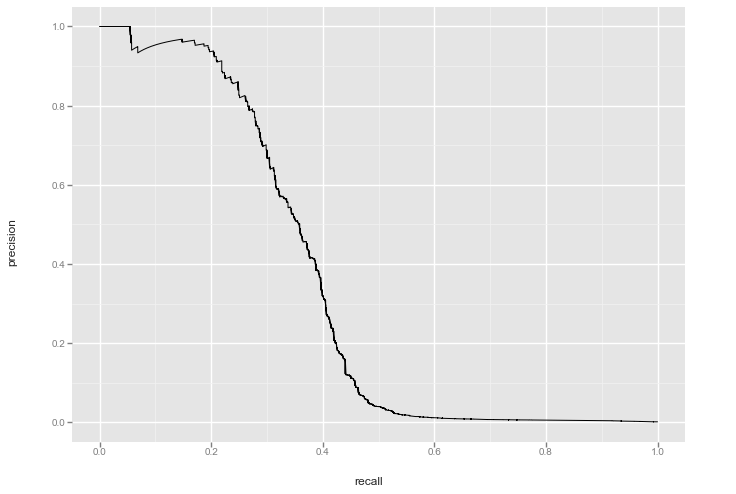

<ggplot: (-9223372036558005472)>

In [15]:
from sklearn.metrics import precision_recall_curve
from ggplot import ggplot, aes, geom_line
y_pred_scores = sgd.decision_function(n_grams_dev)

def plot_precision_recall_curve(y_true, y_pred_scores):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_scores)
    return ggplot(aes(x='recall', y='precision'), 
                  data=pd.DataFrame({"precision": precision, "recall": recall})) + geom_line()
    
plot_precision_recall_curve(y_dev, y_pred_scores)

In [16]:
from sklearn.metrics import average_precision_score
print('Average precision:', average_precision_score(y_dev, y_pred_scores))

Average precision: 0.344992904966


In [17]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

count_vectorizer = CountVectorizer(analyzer='char', min_df=10)
xgb = XGBClassifier(seed=0)
pipeline = Pipeline([
    ('count_vectorizer', count_vectorizer),
    ('xgb', xgb)
])

In [18]:
pipeline.fit(x_train['uri'], y_train)
y_pred = pipeline.predict(x_dev['uri'])
y_pred_proba = pipeline.predict_proba(x_dev['uri'])

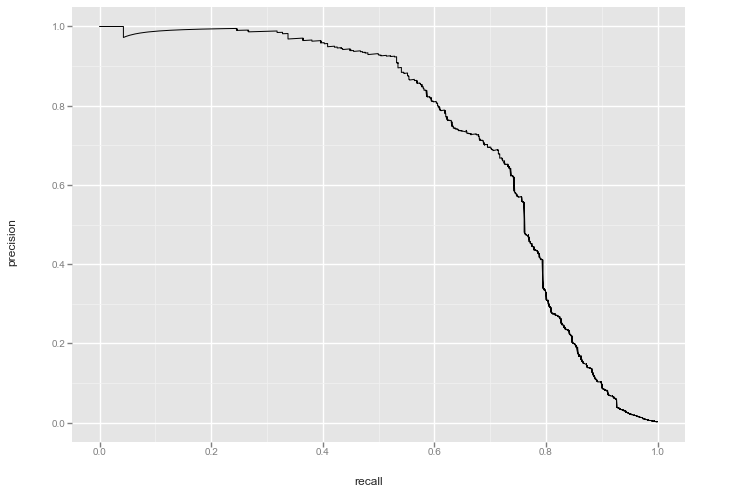

<ggplot: (296705870)>

In [19]:
plot_precision_recall_curve(y_dev, y_pred_proba[:, 1])

In [20]:
print('Average precision:', average_precision_score(y_dev, y_pred_proba[:, 1]))
print('Precision:', precision_score(y_dev, y_pred))
print('Recall:', recall_score(y_dev, y_pred))

Average precision: 0.730001838021
Precision: 0.965189873418
Recall: 0.373317013464


In [21]:
import numpy as np

def get_top_k_indices(l, k=10):
    ind = np.argpartition(l, -k)[-k:]
    return ind[np.argsort(l[ind])[::-1]]

feature_names = {v: k + ' (n_gram)' for k, v in count_vectorizer.vocabulary_.items()}
for idx in get_top_k_indices(xgb.feature_importances_, 10):
    print('Importance: {:.3f} Feature: {}'.format(xgb.feature_importances_[idx], feature_names[idx]))

Importance: 0.094 Feature: . (n_gram)
Importance: 0.088 Feature: / (n_gram)
Importance: 0.078 Feature: 0 (n_gram)
Importance: 0.069 Feature: ) (n_gram)
Importance: 0.055 Feature: = (n_gram)
Importance: 0.040 Feature: x (n_gram)
Importance: 0.030 Feature: * (n_gram)
Importance: 0.029 Feature: g (n_gram)
Importance: 0.029 Feature: & (n_gram)
Importance: 0.026 Feature: ; (n_gram)


In [22]:
head = x_dev[['is_static', 'http_version']].head(10).to_dict(orient='records')
head

[{'http_version': 'v1.1', 'is_static': False},
 {'http_version': 'v1.1', 'is_static': True},
 {'http_version': 'v1.1', 'is_static': True},
 {'http_version': 'v1.1', 'is_static': True},
 {'http_version': 'v1.1', 'is_static': False},
 {'http_version': 'v1.1', 'is_static': True},
 {'http_version': 'v1.1', 'is_static': False},
 {'http_version': 'v2.0', 'is_static': True},
 {'http_version': 'v1.1', 'is_static': False},
 {'http_version': 'v1.1', 'is_static': False}]

In [23]:
from sklearn.feature_extraction import DictVectorizer

dict_vectorizer = DictVectorizer(sparse=False)
dict_vectorizer.fit_transform(head)

array([[ 1.,  0.,  0.],
       [ 1.,  0.,  1.],
       [ 1.,  0.,  1.],
       [ 1.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  1.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.]])

In [24]:
dict_vectorizer.vocabulary_

{'http_version=v1.1': 0, 'http_version=v2.0': 1, 'is_static': 2}

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column_list):
        self.column_list = column_list
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        if len(self.column_list) == 1:
            return x[self.column_list[0]].values
        else:
            return x[self.column_list].to_dict(orient='records')

In [26]:
ColumnSelector(['is_static']).transform(x_dev)[0:5]

array([False,  True,  True,  True, False], dtype=bool)

In [27]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import FeatureUnion

count_vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 3), min_df=10)
dict_vectorizer = DictVectorizer()
xgb = XGBClassifier(seed=0)

pipeline = Pipeline([
    ("feature_union", FeatureUnion([
        ('text_features', Pipeline([
            ('selector', ColumnSelector(['uri'])), 
            ('count_vectorizer', count_vectorizer)
        ])),
        ('categorical_features', Pipeline([
            ('selector', ColumnSelector(['is_static', 'http_version', 'has_referer', 'method'])),
            ('dict_vectorizer', dict_vectorizer)
        ]))
    ])),
    ('xgb', xgb)
])

pipeline.fit(x_train, y_train)

Pipeline(steps=[('feature_union', FeatureUnion(n_jobs=1,
       transformer_list=[('text_features', Pipeline(steps=[('selector', ColumnSelector(column_list=['uri'])), ('count_vectorizer', CountVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-...logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))])

In [28]:
y_pred_proba = pipeline.predict_proba(x_dev)
print('Average precision:', average_precision_score(y_dev, y_pred_proba[:, 1]))

Average precision: 0.960212220102


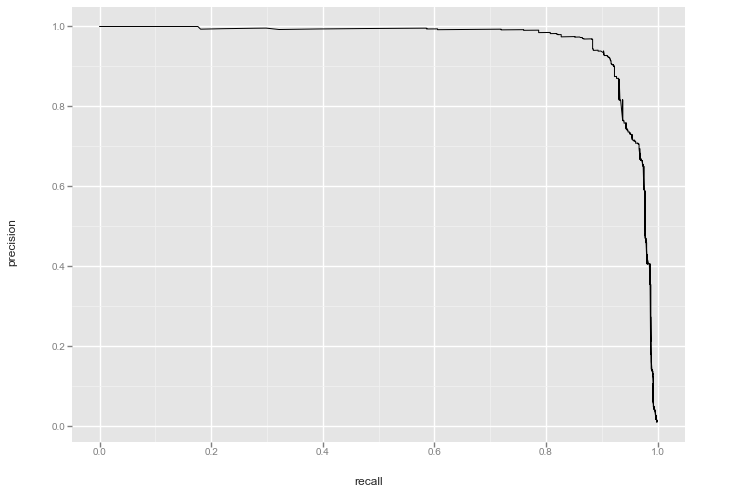

<ggplot: (-9223372036580809093)>

In [29]:
plot_precision_recall_curve(y_dev, y_pred_proba[:, 1])

In [50]:
from collections import defaultdict

indices_1_grams = [v for k, v in count_vectorizer.vocabulary_.items() if len(k) == 1]
indices_2_grams = [v for k, v in count_vectorizer.vocabulary_.items() if len(k) == 2]
indices_3_grams = [v for k, v in count_vectorizer.vocabulary_.items() if len(k) == 3]
indices_categorical = [v + len(count_vectorizer.vocabulary_.items()) for _, v in dict_vectorizer.vocabulary_.items()]

feature_group_importance = defaultdict(int)
for idx, value in enumerate(xgb.feature_importances_):
    if idx in indices_1_grams:
        feature_group_importance['1_grams'] += value
    elif idx in indices_2_grams:
        feature_group_importance['2_grams'] += value
    elif idx in indices_3_grams:
        feature_group_importance['3_grams'] += value
    elif idx in indices_categorical:
        feature_group_importance['categorical'] += value

for key, value in feature_group_importance.items():
    print("Feature set: {} has total importance of : {:.2f}".format(key, value))

Feature set: 1_grams has total importance of : 0.28
Feature set: 2_grams has total importance of : 0.31
Feature set: 3_grams has total importance of : 0.36
Feature set: categorical has total importance of : 0.05
